# 2025-10-10 Polynomial Interpolation

* Interpolation using polynomials

* Structure of generalized Vandermonde matrices

* Conditioning of interpolation and Vandermonde matrices

* Choice of points and choice of basis

See the [FNC](https://fncbook.com/polynomial)

In [1]:
using LinearAlgebra
using Plots
using Polynomials
default(lw=4, ms=5, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

# Here's our Vandermonde matrix again
function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

# Our visualization aids
# Let's use the peanut blob again
function peanut()
    theta = LinRange(0, 2*pi, 50)
    r = 1 .+ .4*sin.(3*theta) + .6*sin.(2*theta)
    r' .* [cos.(theta) sin.(theta)]'
end

# and a perfect circle
function circle()
    theta = LinRange(0, 2*pi, 50)
    [cos.(theta) sin.(theta)]'
end

function Aplot(A)
    "Plot a transformation from X to Y"
    X = peanut()
    Y = A * X
    p = scatter(X[1,:], X[2,:], label="in")
    scatter!(p, Y[1,:], Y[2,:], label="out")
    X = circle()
    Y = A * X
    q = scatter(X[1,:], X[2,:], label="in")
    scatter!(q, Y[1,:], Y[2,:], label="out")
    plot(p, q, layout=2)
end

Aplot (generic function with 1 method)

## What is interpolation?

Given data $\left( x_i, y_i \right)$, find a (smooth?) function $f \left( x \right)$ such that $f \left( x_i \right) = y_i$.

### Data in

* Direct field observations/measurements of physical or social system

* Numerically processed observations, perhaps by applying physical principles

* Output from an expensive "exact" numerical computation

* Output from an approximate numerical computation

### Function out

* Polynomials

* Piecewise polynomials (includes nearest-neighbor)

* Powers and exponentials

* Trigonometric functions (sine and cosine)

* Neural networks

Interpolation fits the data **exactly**!

## Polynomial interpolation

We've seen how we can fit a polynomial using Vandermonde matrices, with one column per basis function and one row per observation.

$$ \underbrace{\Bigg[ 1 \Bigg| x \Bigg| x^2 \Bigg| x^3 \Bigg]}_{A \in \mathbb R^{m\times n}} \Bigg[ \mathbf p \Bigg] = \Bigg[ \mathbf y \Bigg] $$

It's possible to find a unique polynomial **$p$** when which of the following are true?

1) $m \leq n$

2) $m = n$

3) $m \geq n$

### Polynomial interpolation with Vandermonde

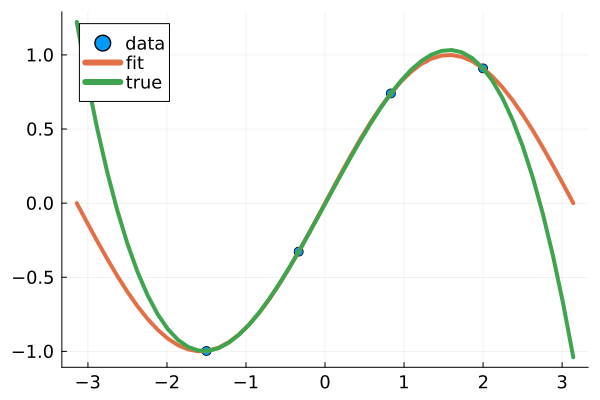

In [2]:
# Let's build some data
x = LinRange(-1.5, 2, 4)
y = sin.(x)

# And find coefficients so that A p = y
A = vander(x)
p = A \ y

# How well did we match?
scatter(x, y, label="data")
s = LinRange(-π, π, 50)
plot!(s, [sin.(s) vander(s, length(p)) * p], label=["fit" "true"])

Recall that Vandermonde matrices can be ill-conditioned.

In [3]:
for i in 1:5
    A = vander(LinRange(-1, 1, 10 * i))
    println("k = $i, cond(A) = $(cond(A))")
end

k = 1, cond(A) = 4626.449923375609
k = 2, cond(A) = 2.7224082423906505e8
k = 3, cond(A) = 1.8388423738279527e13
k = 4, cond(A) = 9.028174036334257e17
k = 5, cond(A) = 5.645434903563094e18


Is this due to the points $x$?

Or is this because of the basis functions $\lbrace 1, x, x^2, x^3, \dots \rbrace$?

Or something else?

## Lagrange interpolating polynomials

Suppose we are given function values $y_0, y_1, \dots, y_m$ at the distinct points $x_0, x_1, \dots, x_m$ and we would like to build a polynomial of degree $m$ that goes through all these points.
This explicit construction is attributed to Lagrange (though he was not first):

$$ p \left( t \right) = \sum_{i=0}^m y_i \prod_{j \ne i} \frac{t - x_j}{x_i - x_j} $$

* What is the degree of this polynomial?

* Why is $p \left( x_i \right) = y_i$?

* How expensive (in terms of $m$) is it to evaluate $p \left( x \right)$?

* How expensive (in terms of $m$) is it to convert to standard form $p \left( x \right) = \sum_{i = 0}^m a_i x^i$?

* Can we easily evaluate the derivative $p' \left( x \right)$?

* What can go wrong? Is this formulation numerically stable?

### Lagrange interpolation in code

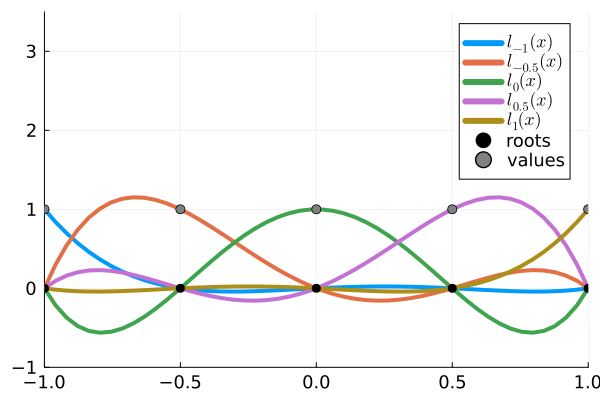

In [4]:
function lagrange(x, y)
    function p(t)
        m = length(x)
        w = 0
        for (i, yi) in enumerate(y)
            w += yi * (prod(t .- x[1:i-1]) * prod(t .- x[i+1:end])
                / (prod(x[i] .- x[1:i-1]) * prod(x[i] .- x[i+1:end])))
        end
        w
    end
    return p
end

# Let's visualize the polynomials
k = 5;
x = LinRange(-1, 1, k)
s = LinRange(-1, 1, 50)
B = vander(s, k) / vander(x)

default(aspect_ratio=:auto)
plot(s, B, label=["\$l_{-1} (x)\$" "\$l_{-0.5} (x)\$" "\$l_0 (x)\$" "\$l_{0.5} (x)\$" "\$l_1 (x)\$"])
scatter!(x, zero.(x), color=:black, ylims=(-1, 3.5), xlims=(-1, 1), label="roots")
scatter!(x, one.(x), color=:grey, ylims=(-1, 3.5), xlims=(-1, 1), label="values")

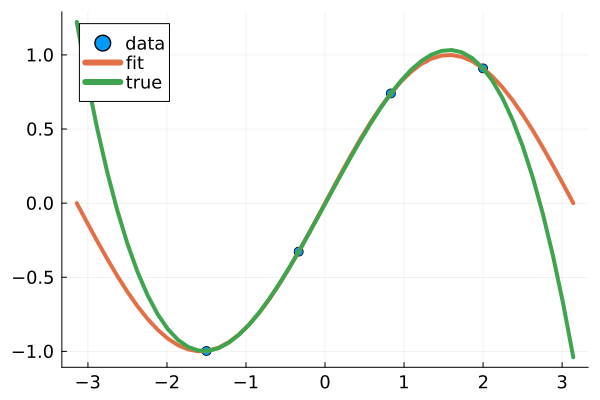

In [5]:
# Use the same example as above
x = LinRange(-1.5, 2, 4)
y = sin.(x)

# Solve
p = lagrange(x, y)

# Plot
scatter(x, y, label="data")
s = LinRange(-π, π, 50)
plot!(s, [sin.(s) p.(s)], label=["fit" "true"])

Note that we do not know `cond(lagrange(x, y))`

This is just a function and we know

$$ \kappa \left( f \right) = \left\lvert f' \right\rvert \frac{\left\lvert x \right\rvert}{\left\lvert f \right\rvert} $$

but this definition depends on the input $x$ and its difficult to explore the space.

We also don't have an easy way to evaluate derivatives.

## Newton polynomials

Newton polynomials are polynomials

$$ n_k \left( x \right) = \prod_{i=0}^{k-1} (x - x_i) $$

This gives the Vandermonde interpolation problem

$$ \Big[ 1 \Big| (x - x_0) \Big| (x - x_0)(x - x_1) \Big| \dotsb \Big] \Big[ p \Big] = \Big[ y \Big] $$

* How does the Vandermonde procedure change if we replace $x^k$ with $n_k \left( x \right)$?

* Does the matrix have recognizable structure?

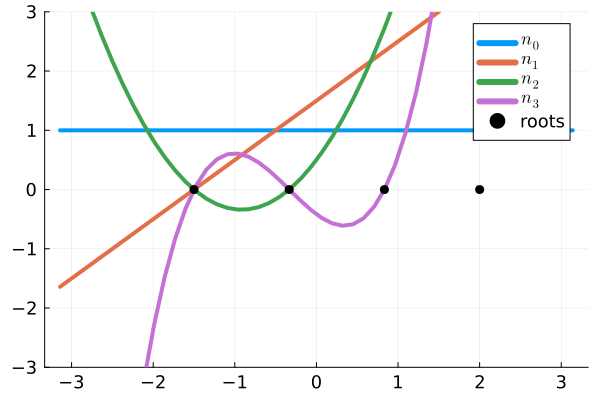

In [6]:
function vander_newton(x, abscissa=nothing)
    if isnothing(abscissa)
        abscissa = x
    end
    n = length(abscissa)
    A = ones(length(x), n)
    for i in 2:n
        A[:, i] = A[:, i-1] .* (x .- abscissa[i-1])
    end
    A
end

# Let's view these polynomials again
s = LinRange(-π, π, 50)
A = vander_newton(s, x)
plot(s, A, ylims=(-3, 3), label=["\$n_0\$" "\$n_1\$" "\$n_2\$" "\$n_3\$"])
scatter!(x, [zero.(x)], color=:black, label="roots")

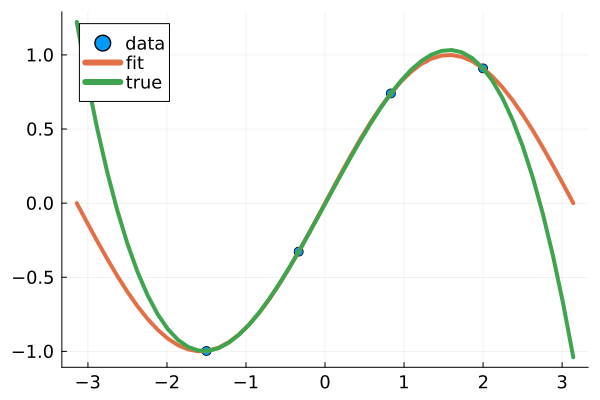

In [7]:
# Let's fit our example curve
x = LinRange(-1.5, 2, 4)
y = sin.(x)

# Solve 
p = vander_newton(x, x) \ y

# Plot
scatter(x, y, label="data")
plot!(s, [sin.(s), vander_newton(s, x) * p], label=["fit" "true"])

### Newton Vandermonde matrix structure

How much does it cost to solve with a general $n \times n$ dense matrix?

1) $\mathcal{O} \left( n \log \left( n \right) \right)$

2) $\mathcal{O} \left( n^2 \right)$

3) $\mathcal{O} \left( n^3 \right)$

In [8]:
vander_newton(LinRange(-1, 1, 5))

5×5 Matrix{Float64}:
 1.0  0.0  -0.0   0.0   -0.0
 1.0  0.5   0.0  -0.0    0.0
 1.0  1.0   0.5   0.0   -0.0
 1.0  1.5   1.5   0.75   0.0
 1.0  2.0   3.0   3.0    1.5

How much does it cost to solve with a Newton Vandermonde matrix?

How is the conditioning of these matrices?

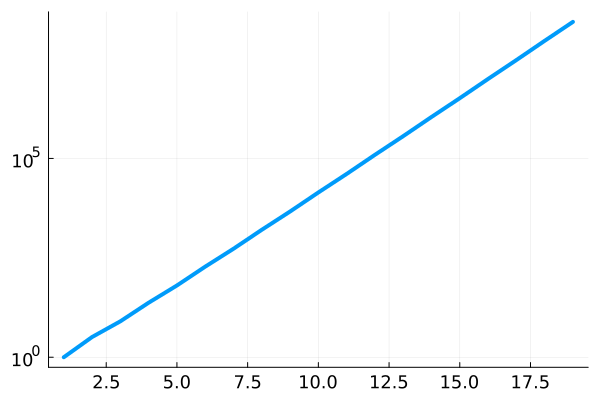

In [9]:
vcond(mat, points, nmax) = [cond(mat(points(-1, 1, n))) for n in 2:nmax]

# Let's start with our original
plot([vcond(vander, LinRange, 20)], yscale=:log10, legend=:none) 

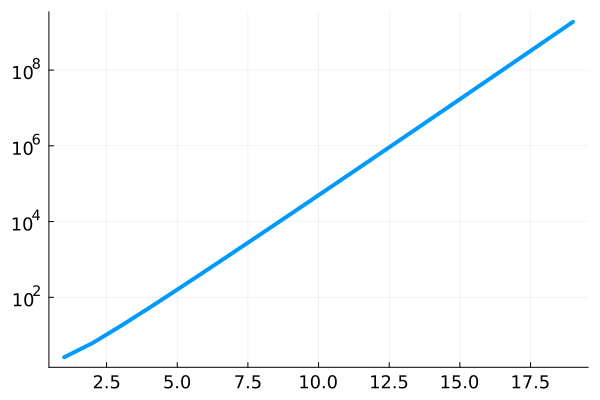

In [10]:
# Maybe Newton is better?
plot([vcond(vander_newton, LinRange, 20)], yscale=:log10, legend=:none) 

## A well-conditioned basis

Recall the Legendre basis from the assignment.

In [11]:
function vander_legendre(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    Q[:, 2] = x
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
    end
    Q
end

vander_legendre (generic function with 2 methods)

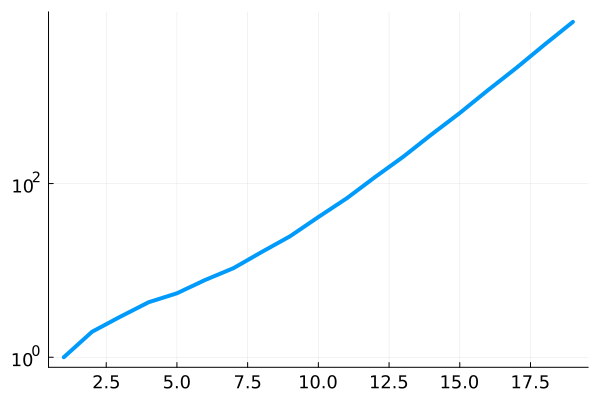

In [12]:
vcond(mat, points, nmax) = [cond(mat(points(-1, 1, n))) for n in 2:nmax]

plot([vcond(vander_legendre, LinRange, 20)], yscale=:log10, legend=:none) 

## Different points

We've looked at different functions, but what about different points $x_i$?

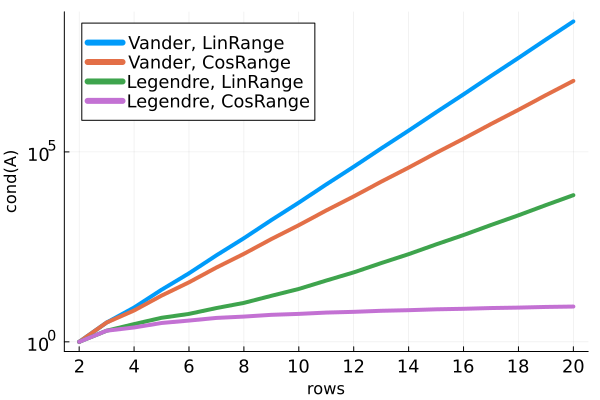

In [13]:
CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

a = 20
plot(range(2, a), [vcond(vander, LinRange, a)], yscale=:log10, legend=:topleft, xticks=range(2, a, step=2), xlabel="rows", ylabel="cond(A)", label="Vander, LinRange")
plot!(range(2, a), [vcond(vander, CosRange, a)], yscale=:log10, label="Vander, CosRange")
plot!(range(2, a), [vcond(vander_legendre, LinRange, a)], yscale=:log10, label="Legendre, LinRange")
plot!(range(2, a), [vcond(vander_legendre, CosRange, a)], yscale=:log10, label="Legendre, CosRange")

## But do we care about ill-conditioning?

What can wrong with poor conditioning?

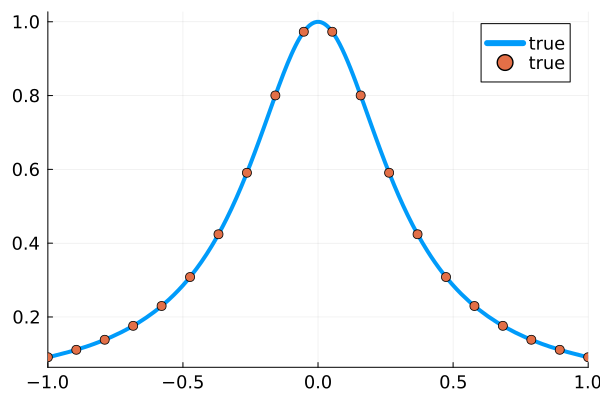

In [14]:
runge1(x) = 1 / (1 + 10*x^2) # What's this "Runge"?

x = LinRange(-1, 1, 20) # try CosRange
y = runge1.(x)
plot(runge1, xlims=(-1, 1), label="true")
scatter!(x, y, label="true")

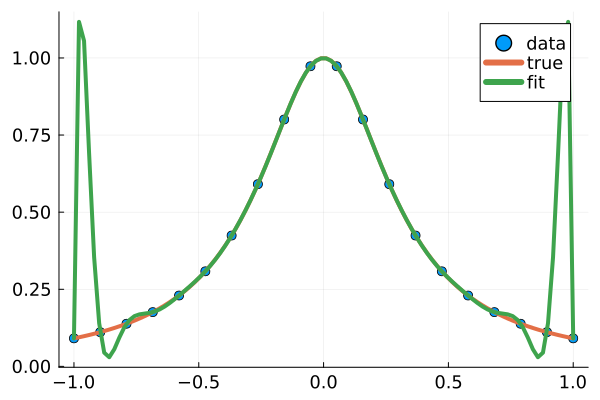

In [15]:
# Let's solve for a fit
ourvander = vander # try vander_legendre
p = ourvander(x) \ y;

# And see how good it is
scatter(x, y, label="data")
s = LinRange(-1, 1, 100)
plot!(s, runge1.(s), label="true")
plot!(s, ourvander(s, length(x)) * p, label="fit")

In [16]:
println("LinRange:")
x = LinRange(-1, 1, 20)
println("  Vander:")
println("    Condition number: $(cond(vander(x)))")
println("  Vander Legendre:")
println("    Condition number: $(cond(vander_legendre(x)))")
println("CosRange:")
x = CosRange(-1, 1, 20)
println("  Vander:")
println("    Condition number: $(cond(vander(x)))")
println("  Vander Legendre:")
println("    Condition number: $(cond(vander_legendre(x)))")

LinRange:
  Vander:
    Condition number: 2.7224082423906505e8
  Vander Legendre:
    Condition number: 7274.598185486983
CosRange:
  Vander:
    Condition number: 7.423193943616384e6
  Vander Legendre:
    Condition number: 8.502660254099549


What is the "worst" normal vector?

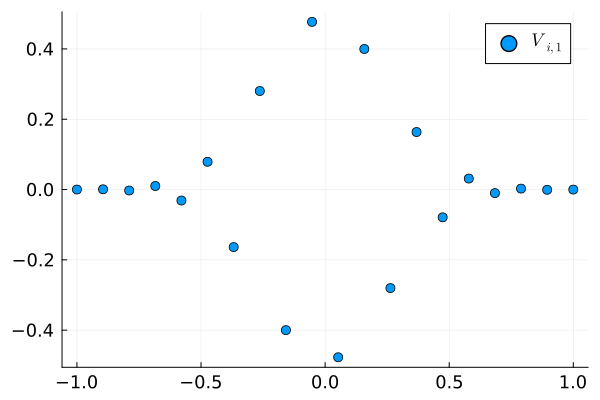

In [17]:
# Try different combinations!
x = LinRange(-1, 1, 20)
ourvander = vander
A = ourvander(s, length(x)) / ourvander(x)

# Decompose and look at V
U, S, V = svd(A)
scatter(x, V[:, 1:1], label="\$V_{i, 1}\$")

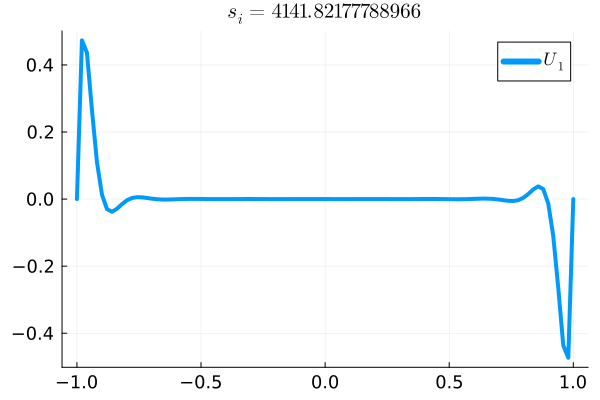

In [18]:
plot(s, U[:,1], title="\$s_i = $(S[1])\$", label="\$U_1\$")

Which combination(s?) gives the least evidence of [**Runge's phenomenon**](https://en.wikipedia.org/wiki/Runge's_phenomenon)? 